In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

!pip install torch torchvision torchaudio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 82.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 60.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
!pip install torch torchvision
!pip install opencv-python
!pip install tqdm scikit-image Pillow pandas

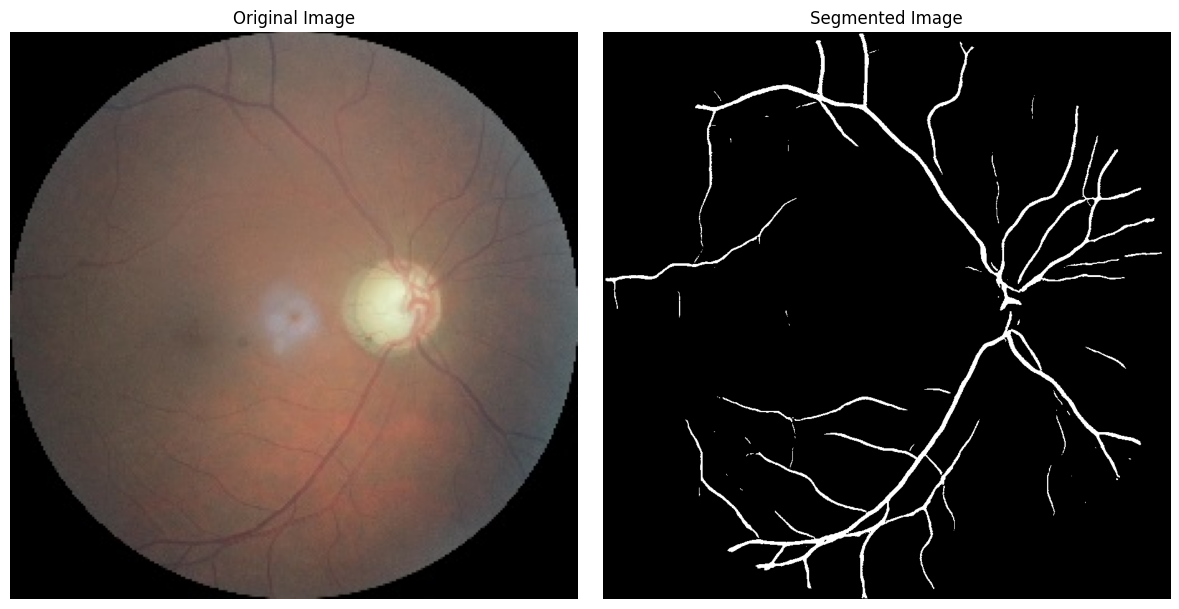

In [ ]:
# -*- coding: utf-8 -*-
"""M3_Vessel.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1Xbe6lTOgFhTpemuDY1dvqsFg-OEs1W9O
"""

import argparse
import os
import numpy as np
import math
import joblib
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch
from os.path import splitext
from os import listdir
from glob import glob
import logging
from torchvision import transforms, utils
import random
from scipy.ndimage import rotate
from PIL import Image, ImageEnhance
import cv2
import pandas as pd
from tqdm import tqdm
import torchvision
from skimage.morphology import skeletonize,remove_small_objects
from skimage import io
import shutil
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from skimage.morphology import skeletonize
from skimage.measure import label, regionprops
from skimage.util import invert
from scipy.spatial.distance import euclidean

class Segmenter(nn.Module):
    def __init__(self, input_channels, n_filters, n_classes, bilinear=False):
        super(Segmenter, self).__init__()

        self.n_channels = input_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(input_channels, n_filters)
        self.down1 = Down(n_filters, 2*n_filters)
        self.down2 = Down(2*n_filters, 4*n_filters)
        self.down3 = Down(4*n_filters, 8*n_filters)
        self.down4 = Down(8*n_filters, 16*n_filters)

        self.up1 = Up_new(16*n_filters, 8*n_filters, bilinear)
        self.up2 = Up_new(8*n_filters, 4*n_filters, bilinear)
        self.up3 = Up_new(4*n_filters, 2*n_filters, bilinear)
        self.up4 = Up_new(2*n_filters, 1*n_filters, bilinear)
        self.outc = OutConv(n_filters, n_classes)


    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


class Discriminator(nn.Module):
    def __init__(self, input_channels, n_filters, n_classes, bilinear=True):
        super(Discriminator, self).__init__()

        self.n_channels = input_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(input_channels, n_filters)
        self.down1 = Down(n_filters, 2*n_filters)
        self.down2 = Down(2*n_filters, 4*n_filters)
        self.down3 = Down(4*n_filters, 8*n_filters)
        self.down4 = Down(8*n_filters, 16*n_filters)

        self.up1 = Up(16*n_filters, 8*n_filters, bilinear)
        self.up2 = Up(8*n_filters, 4*n_filters, bilinear)
        self.up3 = Up(4*n_filters, 2*n_filters, bilinear)
        self.up4 = Up(2*n_filters, 1*n_filters, bilinear)
        self.outc = OutConv(n_filters, n_classes)


    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        mid_channels = out_channels
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=False):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels)

        #else:
        #    self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
        #    self.conv = DoubleConv(in_channels, out_channels)

        else:
            self.conv_bottom = bottom_conv(in_channels, out_channels)
            self.up = nn.Upsample(scale_factor=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.conv_bottom(x1)
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class bottom_conv(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        mid_channels = out_channels
        if not mid_channels:
            mid_channels = out_channels
        self.single_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.single_conv(x)




class DoubleAdd(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.activation = nn.Sequential(
            nn.BatchNorm2d(out_channels//2),
            nn.ReLU(inplace=True),
        )

    def forward(self, x1, x2):

        n, c, h, w = list(x1.size())
        x1 = torch.reshape(input=x1, shape=(n, c // 2, 2, h, w))
        x1 = x1.sum(dim=2)
        x1 = self.activation(x1)

        n, c, h, w = list(x2.size())
        x2 = torch.reshape(input=x2, shape=(n, c // 2, 2, h, w))
        x2 = x2.sum(dim=2)
        x2 = self.activation(x2)
        return torch.cat([x1, x2], dim=1)





class Up_new(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=False):
        super().__init__()
        self.conv_bottom = bottom_conv(in_channels,out_channels)
        self.up = nn.Upsample(scale_factor=2)
        self.add = DoubleAdd(in_channels, out_channels)
        self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x = self.conv_bottom(x1)
        x = self.up(x)
        #road 1

        x_1 = self.add(x,x2)

        #road 2
        x_2 = torch.cat([x, x2], dim=1)
        x_2 = self.conv(x_2)

        return torch.add(x_1, x_2)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class SEDataset_out():
    def __init__(self, img_path, img_size , dataset_name, pthrehold, train_or=True):
        self.img_path = img_path
        self.img_size = img_size
        self.dataset_name = dataset_name
        self.pthrehold = pthrehold
        self.train_or = train_or

        self.img = Image.open(img_path)
        self.ori_width, self.ori_height = self.img.size
        self.img = self.img.resize(self.img_size)
        self.img = self.preprocess(self.img, self.dataset_name, self.img_size, self.train_or, self.pthrehold)

    def __len__(self):
        return 1

    @classmethod
    def pad_img(cls, img, img_size):
        img_h, img_w = img.shape[1], img.shape[2]
        target_h, target_w = img_size[0], img_size[1]
        padded = np.zeros((img.shape[0], target_h, target_w))
        padded[:, (target_h - img_h) // 2:(target_h - img_h) // 2 + img_h,
               (target_w - img_w) // 2:(target_w - img_w) // 2 + img_w] = img
        return padded

    @classmethod
    def random_perturbation(cls, img):
        im = Image.fromarray(img.astype(np.uint8))
        en = ImageEnhance.Color(im)
        im = en.enhance(random.uniform(0.8, 1.2))
        img = np.asarray(im).astype(np.float32)
        return img

    @classmethod
    def preprocess(cls, img, dataset_name, img_size, train_or, pthrehold):
        img_array = np.array(img)

        if np.sum(img_array[..., 2]) == 0:
            img_array = np.concatenate((img_array[..., 1][..., np.newaxis], img_array[..., 1][..., np.newaxis],
                                        img_array[..., 1][..., np.newaxis]), axis=2)
            mean_value = np.mean(img_array[img_array[..., 0] > pthrehold], axis=0)
            std_value = np.std(img_array[img_array[..., 0] > pthrehold], axis=0)
            img_array = (img_array - mean_value) / std_value
        else:
            mean_value = np.mean(img_array[img_array[..., 0] > pthrehold], axis=0)
            std_value = np.std(img_array[img_array[..., 0] > pthrehold], axis=0)
            img_array = (img_array - mean_value) / std_value

        if len(img_array.shape) == 2:
            img_array = np.expand_dims(img_array, axis=2)

        img_array = img_array.transpose((2, 0, 1))

        return img_array

    def __getitem__(self, i):
        img = self.img
        img = self.pad_img(img, self.img_size)
        img = self.random_perturbation(img)

        return {
            'name': 'image',
            'width': self.ori_width,
            'height': self.ori_height,
            'image': torch.from_numpy(img).type(torch.FloatTensor)
        }



def fractal_dimension(Z):

    # Only for 2d image
    assert(len(Z.shape) == 2)

    def boxcount(Z, k):
        S = np.add.reduceat(
            np.add.reduceat(Z, np.arange(0, Z.shape[0], k), axis=0),
                               np.arange(0, Z.shape[1], k), axis=1)

        # We count non-empty (0) and non-full boxes (k*k)
        return len(np.where((S > 0) & (S < k*k))[0])


    # Minimal dimension of image
    p = min(Z.shape)

    # Greatest power of 2 less than or equal to p
    n = 2**np.floor(np.log(p)/np.log(2))

    # Extract the exponent
    n = int(np.log(n)/np.log(2))

    # Build successive box sizes (from 2**n down to 2**1)
    sizes = 2**np.arange(n, 1, -1)

    # Actual box counting with decreasing size
    counts = []
    for size in sizes:
        counts.append(boxcount(Z, size))

    # Fit the successive log(sizes) with log (counts)
    coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)
    # valid_indices = (sizes != 0) & (counts != 0)
    # coeffs = np.polyfit(np.log(sizes[valid_indices]), np.log(counts[valid_indices]), 1)

    return -coeffs[0]


def vessel_density(Z):

    # Only for 2d image
    assert(len(Z.shape) == 2)

    vessel_total_count = np.sum(Z==1)
    pixel_total_count = Z.shape[0]*Z.shape[1]

    return vessel_total_count/pixel_total_count


def calculate_tortuosity(skeleton):
    tortuosities = []

    # Label connected components in the skeleton
    labeled_skel = label(skeleton)

    for region in regionprops(labeled_skel):
        coords = region.coords
        if len(coords) < 10:  # Skip very short segments
            continue

        # Path length = number of pixels in the vessel segment
        path_length = len(coords)

        # Straight-line distance = Euclidean distance between first and last point
        start_point = coords[0]
        end_point = coords[-1]
        straight_line_distance = euclidean(start_point, end_point)

        if straight_line_distance > 0:
            tortuosity = path_length / straight_line_distance
            tortuosities.append(tortuosity)

    if len(tortuosities) == 0:
        return 0  # Avoid division by zero
    return np.mean(tortuosities)


def filter_frag(img):

    # image_list=os.listdir(data_path + 'resize_binary')
    FD_cal=[]
    name_list=[]
    VD_cal=[]
    width_cal=[]

    # img=io.imread(data_path, as_gray=True).astype(np.int64)
    img = cv2.resize(img,(912,912),interpolation = cv2.INTER_NEAREST)
    img2=img>0
    img2 = remove_small_objects(img2, 30, connectivity=5)

    # if not os.path.exists('binary_process/'):
    #   os.makedirs('binary_process/')
    # # cv2.imwrite("Result_1.png", np.float32(img_)*255)
    # io.imsave('binary_process/' , 255*(img2.astype('uint8')),check_contrast=False)

    skeleton = skeletonize(img2)

    # if not os.path.exists(data_path + 'binary_skeleton/'):
    #   os.makedirs(data_path + 'binary_skeleton/')
    # io.imsave(data_path + 'binary_skeleton/' , 255*(skeleton.astype('uint8')),check_contrast=False)

    FD_boxcounting = fractal_dimension(img2)
    VD = vessel_density(img2)
    denominator = np.sum(skeleton)
    width = np.sum(img2) / denominator
    tortuosity = calculate_tortuosity(skeleton)

    FD_cal.append(FD_boxcounting)
    name_list.append(0)
    VD_cal.append(VD)
    width_cal.append(width)

    return FD_cal,name_list,VD_cal,width_cal,tortuosity



def test_net(data_path, image_size, device, threshold, train_or=False):

    FD_list = []
    Name_list = []
    VD_list = []

    dataset_data = SEDataset_out(data_path, image_size, 'testing', threshold, train_or)


    net_1 = Segmenter(input_channels=3, n_filters = 32, n_classes=1, bilinear=False)
    net_2 = Segmenter(input_channels=3, n_filters = 32, n_classes=1, bilinear=False)
    net_3 = Segmenter(input_channels=3, n_filters = 32, n_classes=1, bilinear=False)
    net_4 = Segmenter(input_channels=3, n_filters = 32, n_classes=1, bilinear=False)
    net_5 = Segmenter(input_channels=3, n_filters = 32, n_classes=1, bilinear=False)
    net_6 = Segmenter(input_channels=3, n_filters = 32, n_classes=1, bilinear=False)
    net_7 = Segmenter(input_channels=3, n_filters = 32, n_classes=1, bilinear=False)
    net_8 = Segmenter(input_channels=3, n_filters = 32, n_classes=1, bilinear=False)
    net_9 = Segmenter(input_channels=3, n_filters = 32, n_classes=1, bilinear=False)
    net_10 = Segmenter(input_channels=3, n_filters = 32, n_classes=1, bilinear=False)


    net_1.load_state_dict(torch.load('/content/drive/MyDrive/Glaucoma/m2_weights_vessel/m2_weights_vessel/1_G_best_F1_epoch.pth', map_location=torch.device('cpu'),weights_only=True))
    net_1.eval()
    net_1.to(device=device)
    net_2.load_state_dict(torch.load('/content/drive/MyDrive/Glaucoma/m2_weights_vessel/m2_weights_vessel/2_G_best_F1_epoch.pth', map_location=torch.device('cpu')))
    net_2.eval()
    net_2.to(device=device)
    net_3.load_state_dict(torch.load('/content/drive/MyDrive/Glaucoma/m2_weights_vessel/m2_weights_vessel/3_G_best_F1_epoch.pth', map_location=torch.device('cpu')))
    net_3.eval()
    net_3.to(device=device)
    net_4.load_state_dict(torch.load('/content/drive/MyDrive/Glaucoma/m2_weights_vessel/m2_weights_vessel/4_G_best_F1_epoch.pth', map_location=torch.device('cpu')))
    net_4.eval()
    net_4.to(device=device)
    net_5.load_state_dict(torch.load('/content/drive/MyDrive/Glaucoma/m2_weights_vessel/m2_weights_vessel/5_G_best_F1_epoch.pth', map_location=torch.device('cpu')))
    net_5.eval()
    net_5.to(device=device)
    net_6.load_state_dict(torch.load('/content/drive/MyDrive/Glaucoma/m2_weights_vessel/m2_weights_vessel/6_G_best_F1_epoch.pth', map_location=torch.device('cpu')))
    net_6.eval()
    net_6.to(device=device)
    net_7.load_state_dict(torch.load('/content/drive/MyDrive/Glaucoma/m2_weights_vessel/m2_weights_vessel/7_G_best_F1_epoch.pth', map_location=torch.device('cpu')))
    net_7.eval()
    net_7.to(device=device)
    net_8.load_state_dict(torch.load('/content/drive/MyDrive/Glaucoma/m2_weights_vessel/m2_weights_vessel/8_G_best_F1_epoch.pth', map_location=torch.device('cpu')))
    net_8.eval()
    net_8.to(device=device)
    net_9.load_state_dict(torch.load('/content/drive/MyDrive/Glaucoma/m2_weights_vessel/m2_weights_vessel/9_G_best_F1_epoch.pth', map_location=torch.device('cpu')))
    net_9.eval()
    net_9.to(device=device)
    net_10.load_state_dict(torch.load('/content/drive/MyDrive/Glaucoma/m2_weights_vessel/m2_weights_vessel/10_G_best_F1_epoch.pth', map_location=torch.device('cpu')))
    net_10.eval()
    net_10.to(device=device)

    img = dataset_data.img
    img = torch.from_numpy(img).to(device=device, dtype=torch.float32)
    ori_width = dataset_data.ori_width
    ori_height = dataset_data.ori_height
    img_name = 'image'

    img = img.to(device=device, dtype=torch.float32)
    img = torch.unsqueeze(img, 0)

    with torch.no_grad():
      mask_pred_1 = net_1(img)
      mask_pred_2 = net_2(img)
      mask_pred_3 = net_3(img)
      mask_pred_4 = net_4(img)
      mask_pred_5 = net_5(img)
      mask_pred_6 = net_6(img)
      mask_pred_7 = net_7(img)
      mask_pred_8 = net_8(img)
      mask_pred_9 = net_9(img)
      mask_pred_10 = net_10(img)

    mask_pred_sigmoid_1 = torch.sigmoid(mask_pred_1)
    mask_pred_sigmoid_2 = torch.sigmoid(mask_pred_2)
    mask_pred_sigmoid_3 = torch.sigmoid(mask_pred_3)
    mask_pred_sigmoid_4 = torch.sigmoid(mask_pred_4)
    mask_pred_sigmoid_5 = torch.sigmoid(mask_pred_5)
    mask_pred_sigmoid_6 = torch.sigmoid(mask_pred_6)
    mask_pred_sigmoid_7 = torch.sigmoid(mask_pred_7)
    mask_pred_sigmoid_8 = torch.sigmoid(mask_pred_8)
    mask_pred_sigmoid_9 = torch.sigmoid(mask_pred_9)
    mask_pred_sigmoid_10 = torch.sigmoid(mask_pred_10)
    # segment_fundus(data_path, net_1, net_2, net_3, net_4, net_5, net_6, net_7, net_8, net_9, net_10, test_loader, device, dataset_train, job_name, mask_or, train_or)

    mask_pred_sigmoid=(mask_pred_sigmoid_1+mask_pred_sigmoid_2+mask_pred_sigmoid_3+mask_pred_sigmoid_4+mask_pred_sigmoid_5+mask_pred_sigmoid_6+mask_pred_sigmoid_7+mask_pred_sigmoid_8+mask_pred_sigmoid_9+mask_pred_sigmoid_10)/10
    mask_pred_sigmoid=(mask_pred_sigmoid_1)
    uncertainty_map = torch.sqrt((torch.square(mask_pred_sigmoid-mask_pred_sigmoid_1)+torch.square(mask_pred_sigmoid-mask_pred_sigmoid_2)+torch.square(mask_pred_sigmoid-mask_pred_sigmoid_3)+torch.square(mask_pred_sigmoid-mask_pred_sigmoid_4)+torch.square(mask_pred_sigmoid-mask_pred_sigmoid_5)+torch.square(mask_pred_sigmoid-mask_pred_sigmoid_6)+torch.square(mask_pred_sigmoid-mask_pred_sigmoid_7)+torch.square(mask_pred_sigmoid-mask_pred_sigmoid_8)+torch.square(mask_pred_sigmoid-mask_pred_sigmoid_9)+torch.square(mask_pred_sigmoid-mask_pred_sigmoid_10))/10)

    n_image = mask_pred_sigmoid.shape[0]

    n_ori_width = ori_width
    n_ori_height = ori_height

    mask_pred_resize_bin=torch.zeros(torch.unsqueeze(mask_pred_sigmoid[0,...], 0).shape)
    mask_pred_resize_bin[torch.unsqueeze(mask_pred_sigmoid[0,...], 0)>=0.5]=1
    # save_image(mask_pred_resize_bin, "Results.png")

    image_array = np.float32(mask_pred_resize_bin)*255
    image_array = image_array.squeeze()
    return image_array

def process(img_path, output_path, model_list=None, glaucoma_label=None):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    os.makedirs(output_path, exist_ok=True)

    img = io.imread(img_path).astype(np.float32)
    image_name = os.path.basename(img_path)
    img_size = (912, 912)

    result_image = test_net(
        data_path=img_path,
        image_size=img_size,
        device=device,
        threshold=40,
    )

    output_image_path = os.path.join(output_path, f"segmented_{image_name}.png")
    io.imsave(output_image_path, result_image.astype(np.uint8))

    FD_cal, name_list, VD_cal, width_cal, tortuosity = filter_frag(result_image)

    if not FD_cal or not VD_cal or not width_cal:
        print(f"[❌ Error] Feature extraction failed for: {img_path}")
        return None

    features = {
        "Image Name": image_name,
        "FD_cal": FD_cal[0],
        "VD_cal": VD_cal[0],
        "Width_cal": width_cal[0],
        "Tortuosity": tortuosity
    }

    if glaucoma_label is not None and isinstance(glaucoma_label, (int, float, str)):
        try:
            features["glaucoma_label"] = int(glaucoma_label)
        except ValueError:
            print(f"⚠️ Warning: Could not convert glaucoma_label '{glaucoma_label}' to int for {image_name}")



    return features
# img_path = "/content/drive/MyDrive/Glaucoma/train/RG/EyePACS-Glaucoma-1.jpg"
# output_path = "/content/drive/MyDrive/Glaucoma/sample_output"
# process(img_path, output_path, model_list=None, glaucoma_label=None)


import os
import matplotlib.pyplot as plt
from skimage import io

# Define paths
img_path = "/content/drive/MyDrive/Glaucoma/train/RG/EyePACS-Glaucoma-1.jpg"
output_path = "/content/drive/MyDrive/Glaucoma/sample_output"

# Run the processing
process(img_path, output_path, model_list=None, glaucoma_label=None)

# Load original and segmented images
original_img = io.imread(img_path)
segmented_path = os.path.join(output_path, f"segmented_{os.path.basename(img_path)}.png")
segmented_img = io.imread(segmented_path)

# Plot them side by side
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(original_img.astype("uint8"))
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(segmented_img, cmap='gray')
ax[1].set_title("Segmented Image")
ax[1].axis("off")

plt.tight_layout()
plt.show()



In [ ]:
def process_multiple_images_ml(image_paths, output_path, glaucoma_label=None):
    """
    Processes images for feature extraction.
    If glaucoma_label is provided, it means we are processing training data.
    If glaucoma_label is None, we are processing test data.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    os.makedirs(output_path, exist_ok=True)

    # Load models
    model_list = []
    for i in range(1, 11):
        net = Segmenter(input_channels=3, n_filters=32, n_classes=1, bilinear=False)
        model_path = f'/content/drive/MyDrive/Glaucoma/m2_weights_vessel/m2_weights_vessel/{i}_G_best_F1_epoch.pth'
        net.load_state_dict(torch.load(model_path, map_location=device))
        net.eval()
        net.to(device)
        model_list.append(net)

    all_features = []

    for img_path in tqdm(image_paths, desc="Processing Images"):
        features = process(img_path, output_path, model_list, glaucoma_label)

        if features is None:
            print(f"Skipping {img_path} due to failed feature extraction.")
            continue

        all_features.append(features)

    return all_features


In [ ]:
import os

# Paths for Training Data
positive_train_dir = "/content/drive/MyDrive/Glaucoma/train/RG"  # Glaucoma positive images
negative_train_dir = "/content/drive/MyDrive/Glaucoma/train/NRG"  # Glaucoma negative images
output_train_dir = "/content/drive/MyDrive/Glaucoma/train_result_images"

# Paths for Testing Data
test_dir = "/content/drive/MyDrive/Glaucoma/test"
test_rg_dir = os.path.join(test_dir, "RG")   # Test images with Glaucoma
test_nrg_dir = os.path.join(test_dir, "NRG") # Test images without Glaucoma
output_test_dir = "/content/drive/MyDrive/Glaucoma/test_result_images"

# Model and CSV Paths
model_path = "/content/drive/MyDrive/Glaucoma/glaucoma_detection_model.pkl"  # Saved model
train_csv_path = "/content/drive/MyDrive/Glaucoma/train_features.csv"  # Train CSV file
test_csv_path = "/content/drive/MyDrive/Glaucoma/test_predictions.csv"  # Test Predictions CSV

print(" Paths Set Successfully")


 Paths Set Successfully


In [ ]:
import pandas as pd
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix

def train_ml_model(df_train, model_path):
    print("Training ML model...")

    # Features and labels
    X = df_train[['FD_cal', 'VD_cal', 'Width_cal', 'Tortuosity']]
    y = df_train['glaucoma_label']

    # Train-validation split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train model
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)

    # Validation prediction
    y_val_pred = model.predict(X_val)

    # Evaluation
    acc = accuracy_score(y_val, y_val_pred)
    recall = recall_score(y_val, y_val_pred)
    precision = precision_score(y_val, y_val_pred)
    cm = confusion_matrix(y_val, y_val_pred)

    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    print(f"Validation Accuracy   : {acc:.2f}")
    print(f"Sensitivity (Recall)  : {recall:.2f}")
    print(f"Precision             : {precision:.2f}")
    print(f"Specificity           : {specificity:.2f}")
    print(f"Confusion Matrix:\n{cm.astype(int)}")

    # Save model
    joblib.dump(model, model_path)
    print(f"Trained model saved at: {model_path}")

    return model


In [ ]:
import pandas as pd
import joblib
import os
from sklearn.metrics import accuracy_score, recall_score, precision_score

def test_ml_model(rg_dir, nrg_dir, output_path, model_path, test_csv_path):
    print("Extracting features from test RG (glaucoma) images...")
    rg_images = [os.path.join(rg_dir, fname) for fname in os.listdir(rg_dir) if fname.lower().endswith(('.jpg', '.png'))]
    rg_features = process_multiple_images_ml(rg_images, output_path, glaucoma_label=1)

    print("Extracting features from test NRG (non-glaucoma) images...")
    nrg_images = [os.path.join(nrg_dir, fname) for fname in os.listdir(nrg_dir) if fname.lower().endswith(('.jpg', '.png'))]
    nrg_features = process_multiple_images_ml(nrg_images, output_path, glaucoma_label=0)

    test_features = [f for f in rg_features + nrg_features if f is not None]

    if not test_features:
        raise ValueError("No features extracted from test images.")

    df_test = pd.DataFrame(test_features)

    # Ensure label is numeric and valid
    if "glaucoma_label" in df_test.columns:
        df_test["glaucoma_label"] = pd.to_numeric(df_test["glaucoma_label"], errors='coerce')
        df_test = df_test[df_test["glaucoma_label"].isin([0, 1])]

    # Load model and predict
    model = joblib.load(model_path)
    test_X = df_test[['FD_cal', 'VD_cal', 'Width_cal', 'Tortuosity']]
    df_test['predicted_label'] = model.predict(test_X)

    # Evaluation
    print("\nEvaluation on test data:")
    print(f"Accuracy:  {accuracy_score(df_test['glaucoma_label'], df_test['predicted_label']):.2f}")
    print(f"Recall:    {recall_score(df_test['glaucoma_label'], df_test['predicted_label']):.2f}")
    print(f"Precision: {precision_score(df_test['glaucoma_label'], df_test['predicted_label']):.2f}")

    # Save all features + labels + prediction
    df_test.to_csv(test_csv_path, index=False)
    print(f"\n✅ Test results saved at: {test_csv_path}")


In [ ]:
# Run Paths First
positive_train_paths = [os.path.join(positive_train_dir, img) for img in os.listdir(positive_train_dir)
if img.endswith(('.jpg', '.png'))]
negative_train_paths = [os.path.join(negative_train_dir, img) for img in os.listdir(negative_train_dir)
if img.endswith(('.jpg', '.png'))]

# Extract Features for Training Data
positive_train_features = process_multiple_images_ml(positive_train_paths, output_train_dir, glaucoma_label=1)
negative_train_features = process_multiple_images_ml(negative_train_paths, output_train_dir, glaucoma_label=0)

# Combine Features and Train Model
train_features = positive_train_features + negative_train_features
df_train = pd.DataFrame(train_features)
df_train.to_csv(train_csv_path, index=False)
print(f"Training Features Saved at: {train_csv_path}")

# Train the Model
train_ml_model(df_train, model_path)

# Process Test Images from RG & NRG
test_image_paths = []
for subfolder in [test_rg_dir, test_nrg_dir]:
    if os.path.exists(subfolder):
        test_image_paths.extend(
            [os.path.join(subfolder, img) for img in os.listdir(subfolder) if img.endswith(('.jpg', '.png'))]
        )

print(f"Total Test Images Found: {len(test_image_paths)}")

# Test the Model
test_ml_model(test_image_paths, output_test_dir, model_path, test_csv_path)


Processing Images:   6%|▌         | 20/350 [01:06<17:23,  3.16s/it]/usr/local/lib/python3.11/dist-packages/skimage/_shared/utils.py:328: UserWarning: /content/drive/MyDrive/Glaucoma/train_result_images/segmented_EyePACS-Glaucoma-117.jpg.png is a low contrast image
  return func(*args, **kwargs)
Processing Images:  17%|█▋        | 59/350 [03:15<15:39,  3.23s/it]/usr/local/lib/python3.11/dist-packages/skimage/_shared/utils.py:328: UserWarning: /content/drive/MyDrive/Glaucoma/train_result_images/segmented_EyePACS-Glaucoma-152.jpg.png is a low contrast image
  return func(*args, **kwargs)
Processing Images:  21%|██        | 74/350 [04:01<15:15,  3.32s/it]/usr/local/lib/python3.11/dist-packages/skimage/_shared/utils.py:328: UserWarning: /content/drive/MyDrive/Glaucoma/train_result_images/segmented_EyePACS-Glaucoma-165.jpg.png is a low contrast image
  return func(*args, **kwargs)
Processing Images:  24%|██▎       | 83/350 [04:29<13:24,  3.01s/it]/usr/local/lib/python3.11/dist-packages/skima

✅ Training Features Saved at: /content/drive/MyDrive/Glaucoma/train_features.csv
Training ML model...
Validation Accuracy   : 0.64
Sensitivity (Recall)  : 0.61
Precision             : 0.71
Specificity           : 0.67
Confusion Matrix:
[[41 20]
 [31 48]]
Trained model saved at: /content/drive/MyDrive/Glaucoma/glaucoma_detection_model.pkl
Total Test Images Found: 100
Extracting features from test images...


Processing Images:  11%|█         | 11/100 [00:44<06:09,  4.15s/it]/usr/local/lib/python3.11/dist-packages/skimage/_shared/utils.py:328: UserWarning: /content/drive/MyDrive/Glaucoma/test_result_images/segmented_EyePACS-Glaucoma-2801.jpg.png is a low contrast image
  return func(*args, **kwargs)
Processing Images:  12%|█▏        | 12/100 [00:48<06:25,  4.38s/it]/usr/local/lib/python3.11/dist-packages/skimage/_shared/utils.py:328: UserWarning: /content/drive/MyDrive/Glaucoma/test_result_images/segmented_EyePACS-Glaucoma-2798.jpg.png is a low contrast image
  return func(*args, **kwargs)
Processing Images:  28%|██▊       | 28/100 [01:46<04:13,  3.52s/it]/usr/local/lib/python3.11/dist-packages/skimage/_shared/utils.py:328: UserWarning: /content/drive/MyDrive/Glaucoma/test_result_images/segmented_EyePACS-Glaucoma-2805.jpg.png is a low contrast image
  return func(*args, **kwargs)
Processing Images:  32%|███▏      | 32/100 [02:00<03:57,  3.50s/it]/usr/local/lib/python3.11/dist-packages/skima


Evaluation on test data (with known labels):


ValueError: Classification metrics can't handle a mix of unknown and binary targets

In [ ]:
test_ml_model(test_rg_dir, test_nrg_dir, output_test_dir, model_path, test_csv_path)


Extracting features from test RG (glaucoma) images...


Processing Images:   2%|▏         | 11/500 [00:49<28:06,  3.45s/it]/usr/local/lib/python3.11/dist-packages/skimage/_shared/utils.py:328: UserWarning: /content/drive/MyDrive/Glaucoma/test_result_images/segmented_EyePACS-Glaucoma-2801.jpg.png is a low contrast image
  return func(*args, **kwargs)
Processing Images:   2%|▏         | 12/500 [00:52<26:06,  3.21s/it]/usr/local/lib/python3.11/dist-packages/skimage/_shared/utils.py:328: UserWarning: /content/drive/MyDrive/Glaucoma/test_result_images/segmented_EyePACS-Glaucoma-2798.jpg.png is a low contrast image
  return func(*args, **kwargs)
Processing Images:   6%|▌         | 28/500 [01:40<24:35,  3.13s/it]/usr/local/lib/python3.11/dist-packages/skimage/_shared/utils.py:328: UserWarning: /content/drive/MyDrive/Glaucoma/test_result_images/segmented_EyePACS-Glaucoma-2805.jpg.png is a low contrast image
  return func(*args, **kwargs)
Processing Images:   6%|▋         | 32/500 [01:51<22:29,  2.88s/it]/usr/local/lib/python3.11/dist-packages/skima

Extracting features from test NRG (non-glaucoma) images...


Processing Images:   4%|▍         | 19/500 [01:13<24:11,  3.02s/it]/usr/local/lib/python3.11/dist-packages/skimage/_shared/utils.py:328: UserWarning: /content/drive/MyDrive/Glaucoma/test_result_images/segmented_EyePACS-NRG-2777.jpg.png is a low contrast image
  return func(*args, **kwargs)
Processing Images:   6%|▋         | 32/500 [01:53<22:49,  2.93s/it]/usr/local/lib/python3.11/dist-packages/skimage/_shared/utils.py:328: UserWarning: /content/drive/MyDrive/Glaucoma/test_result_images/segmented_EyePACS-NRG-2807.jpg.png is a low contrast image
  return func(*args, **kwargs)
Processing Images:   9%|▊         | 43/500 [02:26<22:29,  2.95s/it]/usr/local/lib/python3.11/dist-packages/skimage/_shared/utils.py:328: UserWarning: /content/drive/MyDrive/Glaucoma/test_result_images/segmented_EyePACS-NRG-2821.jpg.png is a low contrast image
  return func(*args, **kwargs)
Processing Images:  19%|█▉        | 97/500 [05:05<19:57,  2.97s/it]/usr/local/lib/python3.11/dist-packages/skimage/_shared/util


Evaluation on test data:
Accuracy:  0.63
Recall:    0.63
Precision: 0.62

✅ Test results saved at: /content/drive/MyDrive/Glaucoma/test_predictions.csv


In [ ]:
import pandas as pd
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score,
    f1_score, confusion_matrix, roc_curve, auc
)
import matplotlib.pyplot as plt

# === Load test CSV ===
df = pd.read_csv("/content/drive/MyDrive/Glaucoma/test_predictions.csv")

y_true = df['glaucoma_label']
y_pred = df['predicted_label']
y_prob = df['probability'] if 'probability' in df.columns else None

# === Compute metrics ===
acc = accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

# === Save metrics to text file ===
with open("/content/drive/MyDrive/Glaucoma/performance_metrics_random.txt", "w") as f:
    f.write(f"Accuracy     : {acc:.2f}\n")
    f.write(f"Recall       : {recall:.2f}\n")
    f.write(f"Precision    : {precision:.2f}\n")
    f.write(f"F1 Score     : {f1:.2f}\n")
    f.write(f"Specificity  : {specificity:.2f}\n")
    f.write(f"Confusion Matrix:\n{cm}\n")

print("✅ Metrics saved to performance_metrics_random.txt")

# === Plot ROC curve ===
if y_prob is not None:
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.savefig("roc_curve.png")
    print("✅ ROC curve saved as roc_curve.png")
else:
    print("⚠️ Probability column not found. Skipping ROC curve.")


✅ Metrics saved to performance_metrics.txt
⚠️ Probability column not found. Skipping ROC curve.


In [ ]:
import pandas as pd
import joblib

def predict_single_image(image_path, output_path, model_path):
    print("Processing Single Image for Prediction...")

    # Process Image & Extract Features
    features = process(image_path, output_path, model_list=None, glaucoma_label=None)

    if features is None:
        print("Failed to process the image. No features extracted.")
        return None

    # Print Extracted Features
    print("\n Extracted Features:")
    for key, value in features.items():
        print(f"  {key}: {value}")

    # Convert to DataFrame
    df_single = pd.DataFrame([features])

    # Load Trained Model
    model = joblib.load(model_path)

    # Predict Glaucoma
    test_X = df_single[['FD_cal', 'VD_cal', 'Width_cal', 'Tortuosity']]
    prediction = model.predict(test_X)[0]

    print(f"\n Prediction: {'Glaucoma Detected' if prediction == 1 else 'No Glaucoma'}")
    return prediction

image_path = "/content/drive/MyDrive/Glaucoma/LES-AV_Dataset/glaucoma/Copy of 111.png"
output_path = "/content/drive/MyDrive/Glaucoma/sample_test_output"
model_path = "/content/drive/MyDrive/Glaucoma/glaucoma_model_finetuned.pkl"

predict_single_image(image_path, output_path, model_path)


Processing Single Image for Prediction...

 Extracted Features:
  Image Name: Copy of 111.png
  FD_cal: 1.3626244161557415
  VD_cal: 0.046533548784241305
  Width_cal: 5.85006045949214
  Tortuosity: 1.6047028801931547

 Prediction: Glaucoma Detected


np.int64(1)

In [ ]:
import os
import pandas as pd
import joblib
from glob import glob
from sklearn.ensemble import RandomForestClassifier

# === Set Paths ===
existing_model_path = "/content/drive/MyDrive/Glaucoma/glaucoma_detection_model.pkl"
existing_train_csv = "/content/drive/MyDrive/Glaucoma/train_features.csv"
new_model_path = "/content/drive/MyDrive/Glaucoma/glaucoma_model_finetuned.pkl"
updated_csv_path = "/content/drive/MyDrive/Glaucoma/train_features_finetuned.csv"

# New data folders
new_rg_dir = "/content/drive/MyDrive/Glaucoma/LES-AV_Dataset/glaucoma"   # Label 1
new_nrg_dir = "/content/drive/MyDrive/Glaucoma/LES-AV_Dataset/normal" # Label 0
new_output_dir = "/content/drive/MyDrive/Glaucoma/new_result_images"

# === Helper to extract features ===
def extract_new_features():

    new_rg_paths = glob(os.path.join(new_rg_dir, "*.png"))
    new_nrg_paths = glob(os.path.join(new_nrg_dir, "*.png"))

    features = []
    features += process_multiple_images_ml(new_rg_paths, new_output_dir, glaucoma_label=1)
    features += process_multiple_images_ml(new_nrg_paths, new_output_dir, glaucoma_label=0)

    features = [f for f in features if f is not None]  # Filter failed ones
    return pd.DataFrame(features)

# === Fine-tune the model ===
def fine_tune_model():
    print("Loading existing model and data...")
    existing_df = pd.read_csv(existing_train_csv)
    model = joblib.load(existing_model_path)

    print("Extracting features from new images...")
    new_df = extract_new_features()
    if new_df.empty:
        print("No valid features extracted from new images.")
        return

    print(f"Combining old data ({len(existing_df)}) with new data ({len(new_df)})...")
    updated_df = pd.concat([existing_df, new_df], ignore_index=True)

    X = updated_df[['FD_cal', 'VD_cal', 'Width_cal', 'Tortuosity']]
    y = updated_df['glaucoma_label']

    print("Retraining (fine-tuning) the model...")
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X, y)

    print("Saving updated model and training CSV...")
    joblib.dump(model, new_model_path)
    updated_df.to_csv(updated_csv_path, index=False)

    print("Fine-tuning complete.")
    print(f" New model saved at: {new_model_path}")
    print(f" Updated CSV saved at: {updated_csv_path}")

# === Run ===
fine_tune_model()


Loading existing model and data...
Extracting features from new images...


<ipython-input-6-2e4c2892dd42>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(model_path, map_location=device))
Processing Images:   0%|   

Combining old data (700) with new data (22)...
Retraining (fine-tuning) the model...
Saving updated model and training CSV...
Fine-tuning complete.
 New model saved at: /content/drive/MyDrive/Glaucoma/glaucoma_model_finetuned.pkl
 Updated CSV saved at: /content/drive/MyDrive/Glaucoma/train_features_finetuned.csv


Index(['Image Name', 'FD_cal', 'VD_cal', 'Width_cal', 'Tortuosity',
       'glaucoma_label'],
      dtype='object')


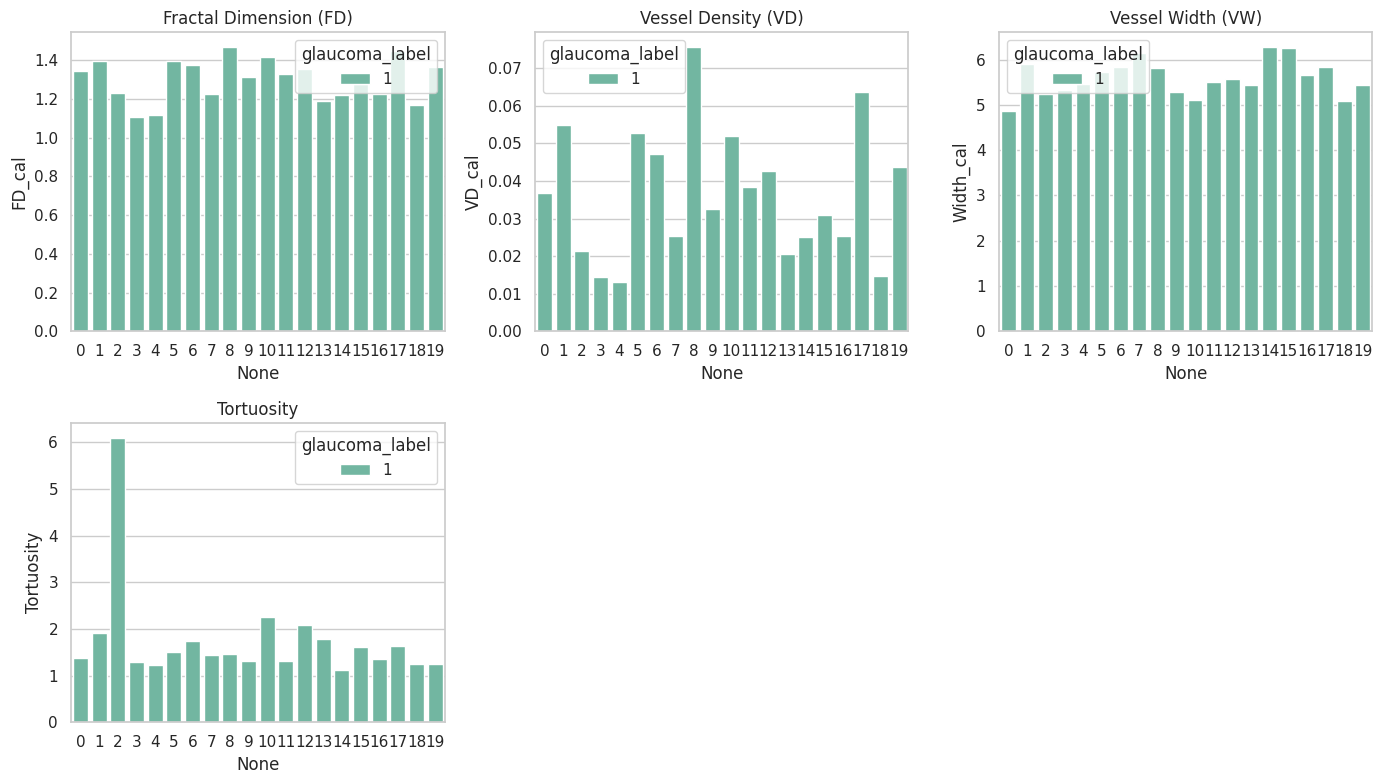

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your CSV file (replace with your actual path)
csv_path = '/content/drive/MyDrive/Glaucoma/train_features_finetuned.csv'
df = pd.read_csv(csv_path)

# Select the first 20 rows
df = df.head(20)

# Optional: Display the column names to verify feature labels
print(df.columns)

# Assuming the following column names (change if needed)
# 'FD' - Fractal Dimension
# 'VD' - Vessel Density
# 'VW' - Vessel Width
# 'Tortuosity' - Vessel Tortuosity
# 'vCDR' - Vertical Cup-to-Disc Ratio
# 'Label' - Glaucoma (1) or Non-Glaucoma (0)

# Set plot style
sns.set(style="whitegrid")

# Plot feature distributions
plt.figure(figsize=(14, 8))

# Subplot 1: FD
plt.subplot(2, 3, 1)
sns.barplot(x=df.index, y='FD_cal', hue='glaucoma_label', data=df, palette='Set2')
plt.title('Fractal Dimension (FD)')

# Subplot 2: VD
plt.subplot(2, 3, 2)
sns.barplot(x=df.index, y='VD_cal', hue='glaucoma_label', data=df, palette='Set2')
plt.title('Vessel Density (VD)')

# Subplot 3: VW
plt.subplot(2, 3, 3)
sns.barplot(x=df.index, y='Width_cal', hue='glaucoma_label', data=df, palette='Set2')
plt.title('Vessel Width (VW)')

# Subplot 4: Tortuosity
plt.subplot(2, 3, 4)
sns.barplot(x=df.index, y='Tortuosity', hue='glaucoma_label', data=df, palette='Set2')
plt.title('Tortuosity')


# Adjust layout
plt.tight_layout()
plt.show()
